In [0]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 4 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,035 kB/s)
debconf: unable to initia

In [0]:
!pip install pytesseract

     |████████████████████████████████| 174kB 1.4MB/s 
  Created wheel for pytesseract: filename=pytesseract-0.2.7-py2.py3-none-any.whl size=165734 sha256=47725724b7106cf6f38bf898e72feffad1dc113e336b9dc8d2213a657ca4f45d
  Stored in directory: /root/.cache/pip/wheels/cd/4a/30/998e01b892300ba0ccce7b806b6e889794605a384dac81a49a
Successfully built pytesseract


In [0]:
ls

sample_data/


In [0]:
import numpy as np
import shutil
import os 
import cv2
import argparse
import time
import pytesseract
from PIL import Image
from imutils.object_detection import non_max_suppression

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
cd /content/drive/My Drive/data


/content/drive/My Drive/data


In [0]:

net = cv2.dnn.readNet('frozen_east_text_detection.pb')
ls

Statement Of Fact.jpg

In [0]:
def document_classifier(image_name):

  image = cv2.imread(image_name)
  orig = image.copy()
  (origH, origW) = image.shape[:2]
  (H, W) = image.shape[:2]
  (newW, newH) = (2560, 2560)
  rW = W / float(newW)
  rH = H / float(newH)
  image = cv2.resize(image, (newW, newH))
  (H, W) = image.shape[:2]
  layerNames = [
    "feature_fusion/Conv_7/Sigmoid",
    "feature_fusion/concat_3"]

  #net = cv2.dnn.readNet('frozen_east_text_detection.pb')# bahar lenna issko

  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)

  start = time.time()
  net.setInput(blob)
  (scores, geometry) = net.forward(layerNames)
  end = time.time()

  (numRows, numCols) = scores.shape[2:4]
  rects = []
  confidences = []

  for y in range(0, numRows):
    # extract the scores (probabilities), followed by the geometrical
    # data used to derive potential bounding box coordinates that
    # surround text
    scoresData = scores[0, 0, y]
    xData0 = geometry[0, 0, y]
    xData1 = geometry[0, 1, y]
    xData2 = geometry[0, 2, y]
    xData3 = geometry[0, 3, y]
    anglesData = geometry[0, 4, y]

    # loop over the number of columns
    for x in range(0, numCols):
      # if our score does not have sufficient probability, ignore it
      if scoresData[x] < 0.5:
        continue

      # compute the offset factor as our resulting feature maps will
      # be 4x smaller than the input image
      (offsetX, offsetY) = (x * 4.0, y * 4.0)

      # extract the rotation angle for the prediction and then
      # compute the sin and cosine
      angle = anglesData[x]
      cos = np.cos(angle)
      sin = np.sin(angle)

      # use the geometry volume to derive the width and height of
      # the bounding box
      h = xData0[x] + xData2[x]
      w = xData1[x] + xData3[x]

      # compute both the starting and ending (x, y)-coordinates for
      # the text prediction bounding box
      endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
      endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
      startX = int(endX - w)
      startY = int(endY - h)

      # add the bounding box coordinates and probability score to
      # our respective lists
      rects.append((startX, startY, endX, endY))
      confidences.append(scoresData[x])

  boxes = non_max_suppression(np.array(rects), probs=confidences)

  aj=[]

  docsAndkeys = { 'NCT' : 'NCT', 'AUTHORITY' : 'LICENCE', 
                 'Cover' : 'GAPINCOVER','notifiable':'Proposal Form',
                 'Motor':'REG DECLARATION','Regulations':'VLC',
                 'vehicles':'Driving LICENCE 2',
                 'Disc':'NCT-CERTIFICATE'}

  for(startX, startY, endX, endY) in boxes:
    startX = int(startX * rW)
    startY =int(startY * rH)
    endX = int(endX * rW)
    endY = int(endY * rH)
    dX = int((endX - startX) * 0.18)
    dY = int((endY - startY) * 0.18)
    startX = max(0, startX - dX)
    startY = max(0, startY - dY)
    endX = min(origW, endX + (dX * 2))
    endY = min(origH, endY + (dY * 2))

    cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
    config = ("-l eng --oem 1 --psm 7")
    copy = orig[startY:endY, startX:endX]
    #plt.imshow(copy)
    #plt.show()
    text = pytesseract.image_to_string(copy, config=config)
    aj.append(text)
    #print(text)
    if(len(aj) > 50):
      break
    #print(startX, startY, endX, endY)

  
  for key in docsAndkeys:
    if any(key in s for s in aj):
      print('yes ' + image_name +' Is '+ str(docsAndkeys[key]))
      doc_class=docsAndkeys[key]
      #directory=os.getcwd()+'/'+str(docsAndkeys[key])
      #if not os.path.exists(directory):
      #  os.makedirs(directory)
      #shutil.move(os.getcwd()+'/'+image_name, directory)
    #else: 
     # print('None' + str(docsAndkeys[key]) )
  return(doc_class)

In [0]:
rr=document_classifier('NCT-DOE.jpg')

yes NCT-DOE.jpg Is NCT


In [0]:
################FINAL WALLA#############
import numpy as np
import cv2
from cv2 import countNonZero
from matplotlib import pyplot as plt
from PIL import Image

def signature_validator(image_name,doc_class):

    crpIm = Image.open(image_name).convert('L')
    
    if doc_class=='GAPINCOVER':
        croppedIm = crpIm.crop((300,1050,900,1200)) #signature - gap on cover
    ####add here for other images with respective coordinates 
    #elif doc_class=='REG DECLARATION':
        #croppedIm= crpIm.crop((,,,))
               
    image_pillow = np.array(croppedIm)
    ret,thresh = cv2.threshold(image_pillow,80,255, cv2.THRESH_BINARY)#80 otherwise shades on scanned doc getting highlighted
    
    width, height = croppedIm.size
    print("size of the image in number of pixels",thresh.size)
    print("non zero",countNonZero(thresh))
    imgplot = plt.imshow(thresh, 'gray')
    plt.show()

    Diffrence = thresh.size - countNonZero(thresh) 
    print(Diffrence)
    if(Diffrence > 600):
         valid  = True
    else:
         valid  = False
    return(valid)


In [0]:
rr

'NCT'

In [0]:
print(aj)

['', 'rBteic 7s!', '', 'Pslock nt', 'of vehicles fo', 'Utimber— 7', '', '', 'if-signaiwe~', 'J wormation- —', '7, 50Ukg |', '<12,000kg |', '| categories of v', '-50c.c. |', '_ Lirthir St', 'i drivers', '| which kk', '_ eamdlacha oh', '{from', 'i valid |', 'fi caiaduinaithe ;', "' 45KmH |", 'ieence iii', 'EUG Lt4-224', 'Jissuéd by', 'tic dmadnal id', '~0.16kWikg |.', 'kw |', 'f birth;', '25kWw |', '(Jissued Gr', '725c.c. |', '2\\900kg|', 'irtiumbcrt', '', '4476', 'TRECAND', '292071944 2', 'amScanner ~', 'sini f4', 'a eishinii J 3s', 'DL', 'Q7-17-12-.', '', '', '', '-| Scanned Wi', 'Co.', 'Off', 'fos', 'avVibuahe']


Put loop here  for multiple images :-
read and path of those images in here 

In [0]:
image = cv2.imread('LICENCE.jpg')

In [0]:
type(image)

numpy.ndarray

In [0]:
orig = image.copy()

In [0]:
(origH, origW) = image.shape[:2]

In [0]:
(H, W) = image.shape[:2]

In [0]:
(newW, newH) = (2560, 2560)
rW = W / float(newW)
rH = H / float(newH)

In [0]:
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]

In [0]:
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [0]:
print("[INFO] loading EAST text detector...")


In [0]:
net = cv2.dnn.readNet('frozen_east_text_detection.pb')

In [0]:
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)


In [0]:
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()

In [0]:
print("[INFO] text detection took {:.6f} seconds".format(end - start))

In [0]:
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

In [0]:
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < 0.5:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]

		# compute both the starting and ending (x, y)-coordinates for
		# the text prediction bounding box
		endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
		endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
		startX = int(endX - w)
		startY = int(endY - h)

		# add the bounding box coordinates and probability score to
		# our respective lists
		rects.append((startX, startY, endX, endY))
		confidences.append(scoresData[x])

In [0]:
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [0]:
import matplotlib.pyplot as plt
aj=[]
iff=[]

In [0]:
for(startX, startY, endX, endY) in boxes:
  startX = int(startX * rW)
  startY =int(startY * rH)
  endX = int(endX * rW)
  endY = int(endY * rH)
  dX = int((endX - startX) * 0.18)
  dY = int((endY - startY) * 0.18)
  startX = max(0, startX - dX)
  startY = max(0, startY - dY)
  endX = min(origW, endX + (dX * 2))
  endY = min(origH, endY + (dY * 2))
  
  cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)
  config = ("-l eng --oem 1 --psm 7")
  copy = orig[startY:endY, startX:endX]
  #plt.imshow(copy)
  #plt.show()
  text = pytesseract.image_to_string(copy, config=config)
  aj.append(text)
  print(text)
  #print(startX, startY, endX, endY)

i5 ENGLAND
| SAFETY Al
"Y AUTHORITY
1. 270131712
IDAN<<<<Z01<0100UA
BH CEADUNAS TIOI
D<SHERIDA
; O100UA22SV.
IRELAND |
STIOMANA DR
BRER,KELLS,
RIVING LICENCE.
<0100UA22S015_ |
FIRE
ROAM S,
i


02.07.

12 {5 E
Orr
bb
4a.
(AC.
Reena iy.
An


In [0]:
from matplotlib import pyplot as plt

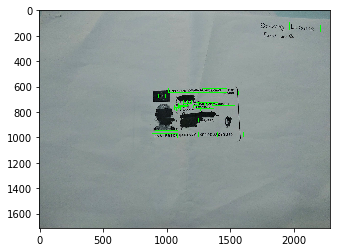

In [0]:
plt.imshow(orig)
plt.show()

In [0]:
print(aj)
type(aj)

['i5 ENGLAND', '| SAFETY Al', '"Y AUTHORITY', '1. 270131712', 'IDAN<<<<Z01<0100UA', 'BH CEADUNAS TIOI', 'D<SHERIDA', '; O100UA22SV.', 'IRELAND |', 'STIOMANA DR', 'BRER,KELLS,', 'RIVING LICENCE.', '<0100UA22S015_ |', 'FIRE', 'ROAM S,', 'i', '', '', '02.07.', '', '12 {5 E', 'Orr', 'bb', '4a.', '(AC.', 'Reena iy.', 'An']


list

In [0]:
docsAndkeys = { 'NCT' : 'NCT', 'AUTHORITY' : 'LICENCE', 'Cover' : 'GAPINCOVER'} 
#aj=['last f', '» this \\', 'y accident,-cle', '/ ended, e', 'ir pending pr', 'been i', 'that |', 'has ;', 'ysince _', 'drive ¢', '‘held r', 'who 1', '| declare th', 't noted o', 'or insuranceisin', 'not |', ') any f', '-claim, |', 'on', '| rnotor ir', 'No |', 'have r', 'Cover D', 'has |', 'convictions cr |', 'Date:', 'er Declaration —', 'J prosecutions sin', 'will', '; since', '; vehicle hz', 'the |', '| form.', 'n involved in', 't policy e', '/ points,', 'lany é', '“because. _', 'in,', 'or', 'o i9erson WI', '> proposal for', 'y nenalty pc', 'Gap i', ', except ne', 'Signed: .', 'my |', 'in', '', '', '', 'i tes hb', "CGS '"]

In [0]:
for x in docsAndkeys:
  if any(x in s for s in aj):
    print('yes')
      
    print(docsAndkeys[x])
  else: 
    print('no')


no
yes
LICENCE
no


In [0]:
import shutil
import os 
for key in docsAndkeys:
  if any(key in s for s in aj):
    print('yes  ' + str(docsAndkeys[key]))
    directory=os.getcwd()+'/'+str(docsAndkeys[key])
    if not os.path.exists(directory):
      os.makedirs(directory)
    shutil.move(os.getcwd()+'/'+"Licence.jpg", directory)
    print(docsAndkeys[key])
  else: 
    print('not a  ' + str(docsAndkeys[key]) )

not a  NCT
yes  LICENCE
LICENCE
not a  GAPINCOVER


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import shutil
  
shutil.move("/content/drive/My Drive/data/car_wash.png", '/content/drive/My Drive/data/classified/'+str(dk[0]))



'/content/drive/My Drive/data/classified/GAPINCOVER/car_wash.png'

In [0]:
dk=['GAPR']

In [0]:
directory='/content/drive/My Drive/data/classified/'+str(dk[0])
if not os.path.exists(directory):
    os.makedirs(directory)

In [0]:

import os

print(os.getcwd()+'/'+"LICENCE.jpg")

/content/drive/My Drive/data/LICENCE.jpg
